/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


1.15.0
Average score over 10 episodes at episode 10 : -200.0
Average score over 10 episodes at episode 20 : -200.0
Average score over 10 episodes at episode 30 : -200.0
Average score over 10 episodes at episode 40 : -200.0
Average score over 10 episodes at episode 50 : -200.0
Average score over 10 episodes at episode 60 : -200.0
Average score over 10 episodes at episode 70 : -200.0
Average score over 10 episodes at episode 80 : -200.0
Average score over 10 episodes at episode 90 : -200.0
Average score over 10 episodes at episode 100 : -200.0
Average score over 10 episodes at episode 110 : -200.0
Average score over 10 episodes at episode 120 : -200.0
Average score over 10 episodes at episode 130 : -200.0
Average score over 10 episodes at episode 140 : -200.0
Average score over 10 episodes at episode 150 : -200.0
Average score over 10 episodes at episode 160 : -200.0
Average score over 10 episodes at episode 170 : -200.0
Average score over 10 episodes at episode 180 : -197.5
Average scor

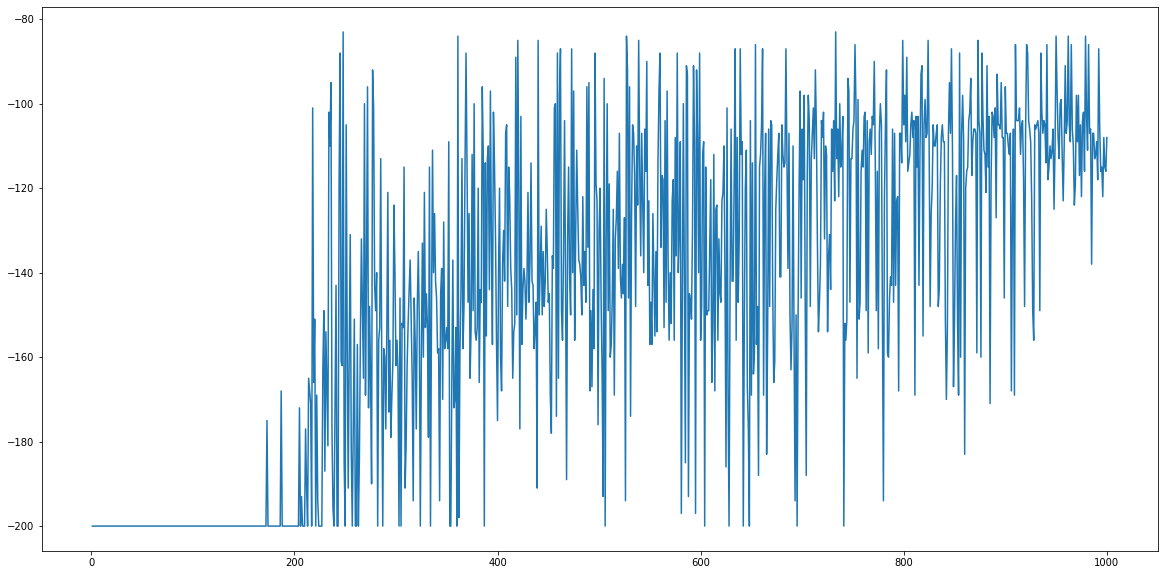

In [0]:
import random
from itertools import count
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import gym
import tensorflow
from tensorflow.keras import models, layers
from tensorflow.keras.initializers import glorot_normal
from collections import deque
from tensorflow.keras.optimizers import Adam

### Environment ##
MODE = 'train'
ENV = gym.make('MountainCar-v0')
OBSERVATION_SPACE = ENV.observation_space.shape[0]
ACTION_SPACE = ENV.action_space.n

### Hyperparameters ###
LR = 0.0003
BATCH_SIZE = 64
GAMMA = 0.99

EPISODES = 1000
MEM_SIZE = 100000
EXPLORATION_RATE = 0.95
EXPLORATION_DECAY = 0.99

print(tensorflow.__version__)

class Agent:

  def __init__(self):
    # Replay memory
    self.memory = deque(maxlen=MEM_SIZE)
    # Initalize action policy
    self.action_policy = self.DQNet()
    self.epsilon = EXPLORATION_RATE

  def DQNet(self):
    model = models.Sequential([
    layers.Dense(512, input_dim = OBSERVATION_SPACE, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(ACTION_SPACE, activation='linear')])
    model.compile(optimizer=Adam(learning_rate=LR),
              loss='mse')
    return model

  def sample_action(self, observation):
    # Exploration rate decays with each action taken
    self.epsilon *= EXPLORATION_DECAY
    # Choose random action or act greedily according to the current policy
    if random.random() < self.epsilon:
      return np.random.choice(ACTION_SPACE, 1)[0]
    else:
      return np.argmax(self.action_policy.predict(observation))

  # Add observation to replay memory
  def add_to_memory(self, ts):
    self.memory.append(ts)  

  def transform_samples(self, batch):
      s = np.array([i[0] for i in batch])
      a = np.array([i[1] for i in batch])
      r = np.array([i[2] for i in batch])
      next_s = np.array([i[3] for i in batch])
      dones = np.array([i[4] for i in batch])
      s = np.squeeze(s)
      next_s = np.squeeze(next_s)
      return s, a, r, next_s, dones
    
  def replay_from_memory(self):
    # Assert we have enough observation instances in our memory
    if len(self.memory) < BATCH_SIZE*4:
      return
    else:
      x_batch, y_batch = [], []
      batch = random.sample(self.memory, BATCH_SIZE)
      s, a, r, next_s, dones = self.transform_samples(batch)
      # Get targets
      targets = r + GAMMA*(np.max(self.action_policy.predict_on_batch(next_s), axis=1))*(1-dones)
      actual = self.action_policy.predict_on_batch(s)
      ind = np.array(range(BATCH_SIZE))
      actual[ind, a] = targets
      # Perform gradient update
      self.action_policy.fit(s, actual, epochs=1, verbose = 0)
      
class Env:

  def __init__(self, env, mode='train'):
    self.env = env
    self.agent = Agent()
    self.episode = 0
    self.scores = 0
    self.chart_performance = []
    if mode == 'play':
      self.play_once()
    else:
      self.train()

  def train(self):
    # Start playing
    for episode in range(EPISODES):
      self.play_episode()
    # Save model
    self.agent.action_policy.save_weights('dqn_weights.h5')
    # Plot scores for each episode when done training
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(1, EPISODES+1), self.chart_performance)
    plt.show()

  def play_episode(self):
    observation = self.env.reset().reshape(1,OBSERVATION_SPACE)
    counter = 0
    while True:
      action = self.agent.sample_action(observation)
      next_observation, reward, done, info = self.env.step(action)
      next_observation = next_observation.reshape(1,OBSERVATION_SPACE)
      # Store transition tuple in replay memory
      self.agent.add_to_memory((observation, action, reward, next_observation, done))
      counter += reward
      # Update statistics at the end of each episode
      if done:
        self.episode += 1
        self.scores += counter
        self.chart_performance.append(counter)
        if self.episode % 10 == 0:
          print("Average score over 10 episodes at episode {} : {}".format(self.episode, self.scores/10))
          self.scores = 0
        break
      observation = next_observation
      # Experience replay
      self.agent.replay_from_memory()

  # Play a single game with pre-trained model
  def play_once(self):
      self.agent.action_policy.load_weights('dqn_weights_cartpole.h5')
      observation = self.env.reset().reshape(1,OBSERVATION_SPACE)
      print(observation.shape)
      while True:
          self.env.render()
          action = np.argmax(self.agent.action_policy.predict(observation))
          next_observation, reward, done, info = self.env.step(action)
          if done:
              break
          next_observation = next_observation.reshape(1,OBSERVATION_SPACE)
          observation = next_observation
        
if __name__ == '__main__':
  env = Env(ENV, MODE)